# Task 3: Interpret the Embedding Space



In [1]:
# Ensure repo root is on sys.path for `utils` imports
from pathlib import Path
import sys
repo_root = Path.cwd().parent
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))
print('Added to sys.path:', repo_root)


Added to sys.path: /cs/student/projects1/aibh/2024/rmaheswa/Helical_Task/als-perturb-geneformer


In [2]:
import os
os.environ["PIP_CACHE_DIR"] = "/cs/student/projects1/aibh/2024/rmaheswa/cache"
os.environ["HF_HOME"] = "/cs/student/projects1/aibh/2024/rmaheswa/cache/huggingface"
os.environ["TRANSFORMERS_CACHE"] = "/cs/student/projects1/aibh/2024/rmaheswa/cache/transformers"

In [3]:
from pathlib import Path
import numpy as np
import pandas as pd

from utils.metrics import (
    centroid, delta_to_healthy, wasserstein1d_along_pc, knn_overlap_fraction,
    silhouette_scores_by_label, composite_score
)
from utils.plotting import umap_2d, plot_umap, plot_centroid_shifts

# Use absolute paths matching Task 2 outputs
EMB_DIR = Path('/cs/student/projects1/aibh/2024/rmaheswa/Helical_Task/als-perturb-geneformer/als-perturb-geneformer/data/embeddings')
FIG_DIR = Path('/cs/student/projects1/aibh/2024/rmaheswa/Helical_Task/als-perturb-geneformer/als-perturb-geneformer/data/figs')
FIG_DIR.mkdir(parents=True, exist_ok=True)

# Load embeddings saved in Task 2
healthy_path = EMB_DIR / 'healthy_base.npz'
als_path = EMB_DIR / 'als_base.npz'
if not (healthy_path.exists() and als_path.exists()):
    raise FileNotFoundError("Missing healthy_base.npz or als_base.npz. Run notebook 02 first.")

healthy = np.load(healthy_path)['arr']
als = np.load(als_path)['arr']

# Load perturbation embeddings
pert_embeddings = {}
for p in sorted(EMB_DIR.glob('healthy_*_up.npz')):
    pert_embeddings[p.stem.replace('healthy_', '')] = np.load(p)['arr']
for p in sorted(EMB_DIR.glob('als_*_down.npz')):
    pert_embeddings[p.stem.replace('als_', '')] = np.load(p)['arr']

# Metrics
rows = []
for name, emb_als_pert in pert_embeddings.items():
    d_health = delta_to_healthy(als, emb_als_pert, healthy)
    w1d = wasserstein1d_along_pc(als, healthy)
    w1d_after = wasserstein1d_along_pc(emb_als_pert, healthy)
    knn_gain = knn_overlap_fraction(healthy, emb_als_pert, k=15) - knn_overlap_fraction(healthy, als, k=15)
    sil_base = silhouette_scores_by_label(np.vstack([healthy, als]), ['healthy']*len(healthy)+['als']*len(als))
    sil_after = silhouette_scores_by_label(np.vstack([healthy, emb_als_pert]), ['healthy']*len(healthy)+['als_pert']*len(emb_als_pert))
    rows.append({
        'perturbation': name,
        'delta_to_healthy': d_health,
        'wasserstein_before': w1d,
        'wasserstein_after': w1d_after,
        'knn_overlap_gain': knn_gain,
        'silhouette_before': sil_base,
        'silhouette_after': sil_after,
    })

metrics_df = pd.DataFrame(rows)
metrics_df.to_csv(FIG_DIR / 'task3_metrics.csv', index=False)

print("✓ Metrics computed and saved to:", FIG_DIR / 'task3_metrics.csv')


/cs/student/projects1/aibh/2024/rmaheswa/Helical_Task/.venv-gf310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ Metrics computed and saved to: /cs/student/projects1/aibh/2024/rmaheswa/Helical_Task/als-perturb-geneformer/als-perturb-geneformer/data/figs/task3_metrics.csv


/cs/student/projects1/aibh/2024/rmaheswa/Helical_Task/.venv-gf310/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


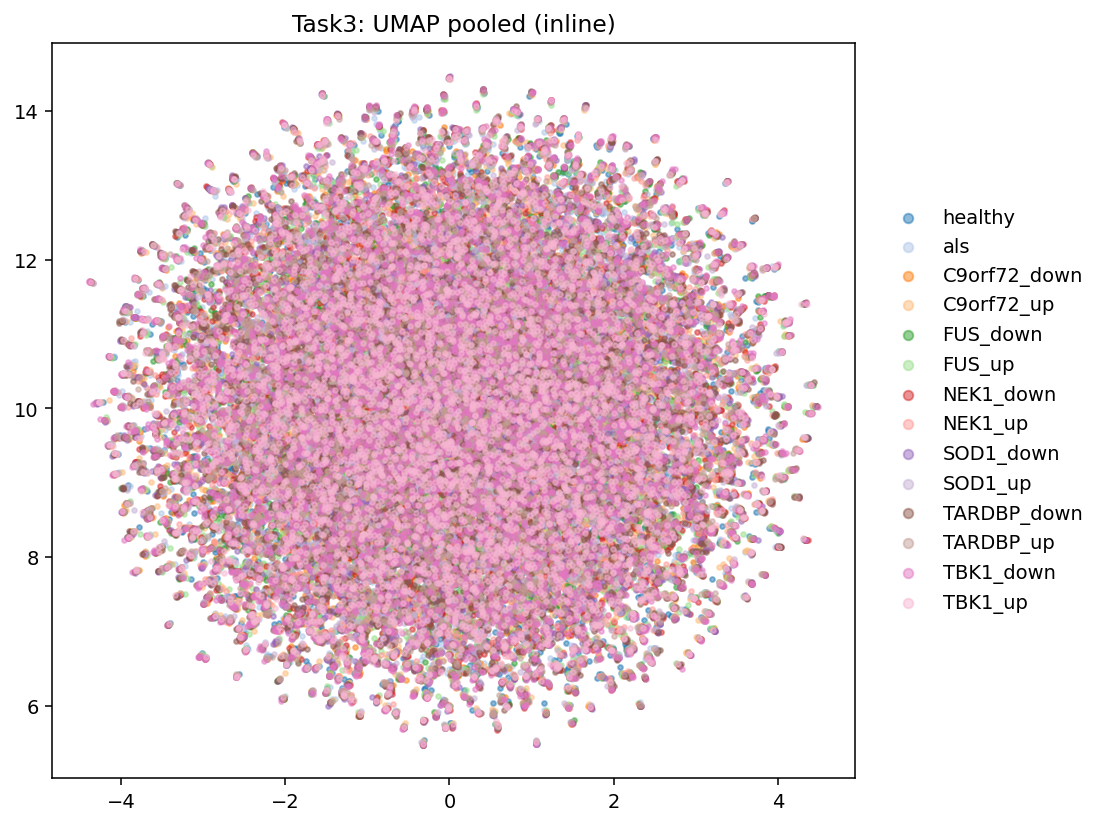

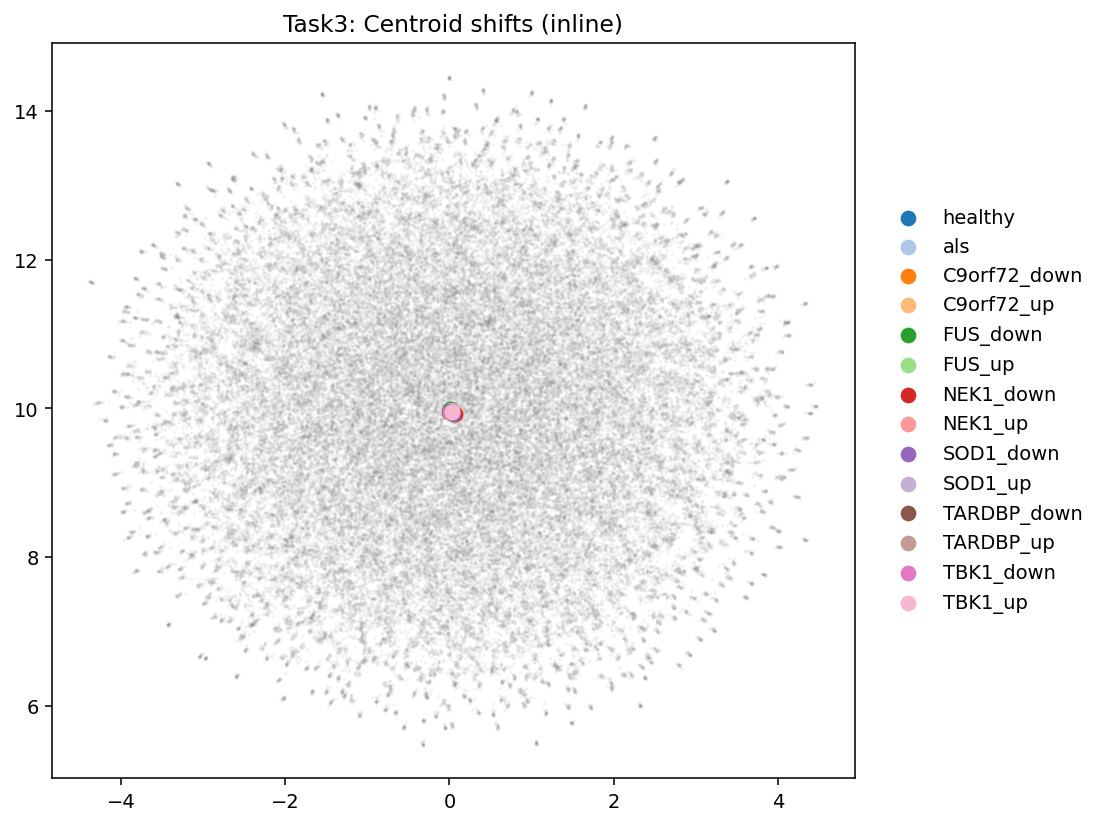

,perturbation,delta_to_healthy,wasserstein_before,wasserstein_after,knn_overlap_gain,silhouette_before,silhouette_after
0,C9orf72_up,0.0000,0.0000,0.0000,0.0000,0.0004,0.0004
1,FUS_up,0.0000,0.0000,0.0000,0.0000,0.0004,0.0004
2,NEK1_up,0.0000,0.0000,0.0000,0.0000,0.0004,0.0004
3,SOD1_up,0.0000,0.0000,0.0000,0.0000,0.0004,0.0004
4,TARDBP_up,0.0000,0.0000,0.0000,0.0000,0.0004,0.0004
5,TBK1_up,0.0000,0.0000,0.0000,0.0000,0.0004,0.0004
6,C9orf72_down,0.0000,0.0000,0.0000,0.0000,0.0004,0.0004
7,FUS_down,0.0000,0.0000,0.0000,0.0000,0.0004,0.0004
8,NEK1_down,0.0000,0.0000,0.0000,0.0000,0.0004,0.0004
9,SOD1_down,0.0000,0.0000,0.0000,0.0000,0.0004,0.0004


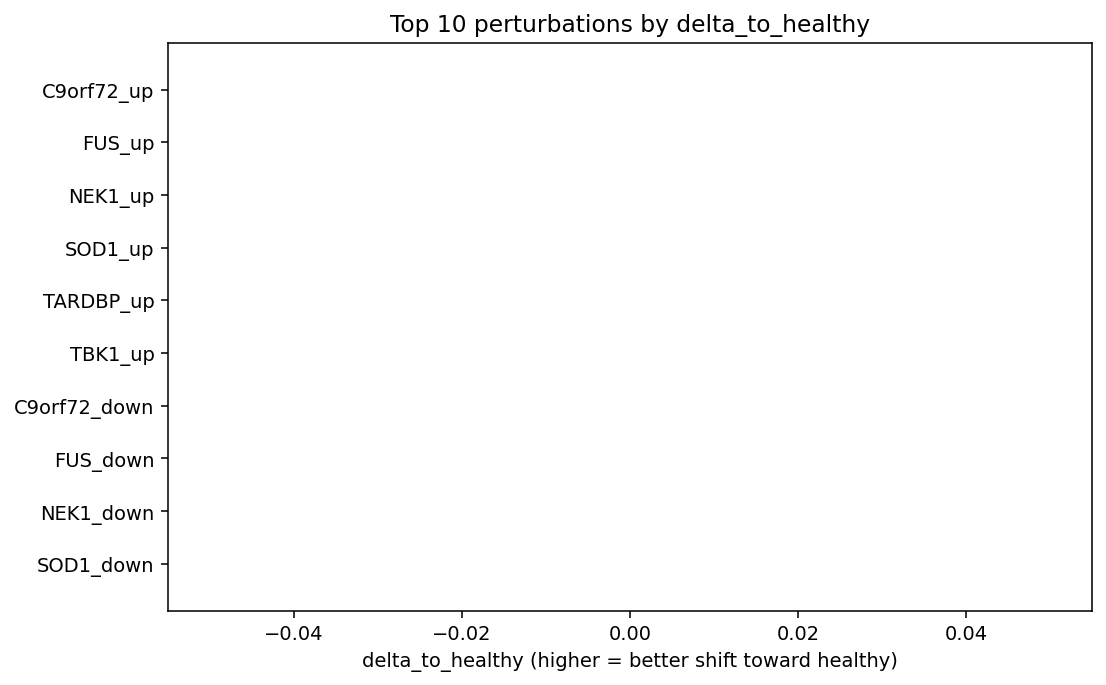

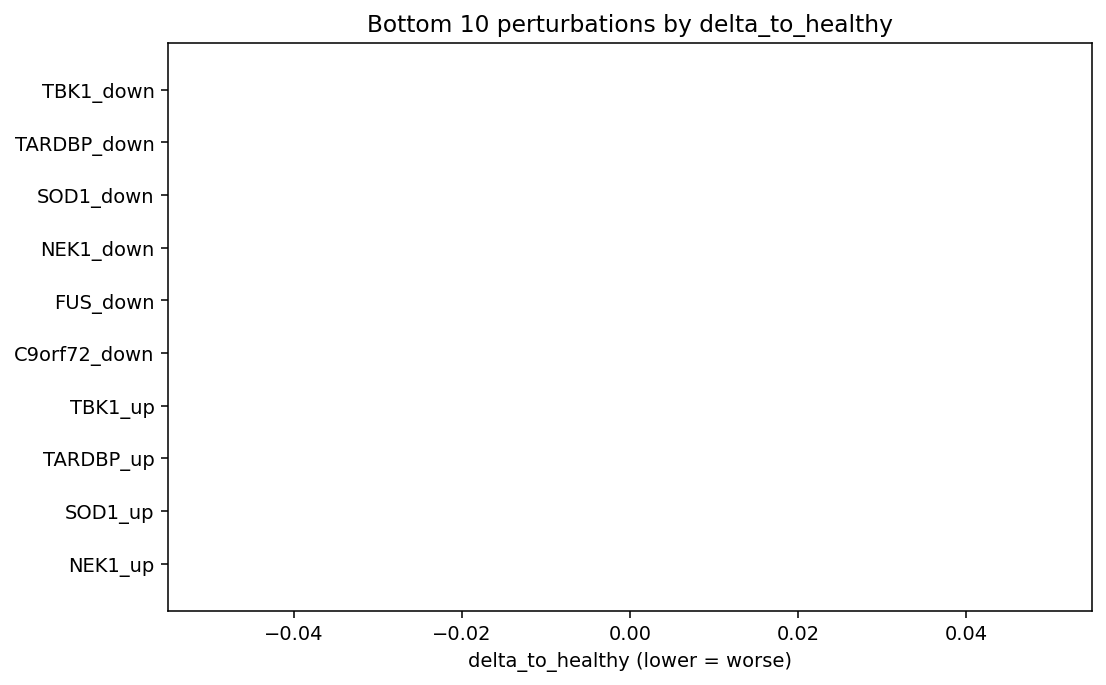

In [7]:
# Inline interpretation (no PNGs) — UMAP + centroids + ranked metrics
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 1) UMAP pooled (recompute from already-loaded arrays)
pool = [healthy, als] + list(pert_embeddings.values())
labels = (['healthy'] * len(healthy) +
          ['als'] * len(als) +
          sum([[k] * len(v) for k, v in pert_embeddings.items()], []))
X = np.vstack(pool)
pts = umap_2d(X)

categories = ['healthy', 'als'] + sorted(pert_embeddings.keys())
palette = {c: plt.cm.tab20(i % 20) for i, c in enumerate(categories)}
label_arr = np.array(labels)

plt.figure(figsize=(8, 6), dpi=140)
for c in categories:
    m = (label_arr == c)
    plt.scatter(pts[m, 0], pts[m, 1], s=6, alpha=0.5, c=[palette[c]], label=c)
plt.title('Task3: UMAP pooled (inline)')
plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False, markerscale=2)
plt.tight_layout()
plt.show()

# 2) Centroid shifts (inline)
plt.figure(figsize=(8, 6), dpi=140)
plt.scatter(pts[:, 0], pts[:, 1], s=1, alpha=0.06, color='gray')
for c in categories:
    m = (label_arr == c)
    center = pts[m].mean(axis=0)
    plt.scatter(center[0], center[1], s=50, c=[palette[c]], label=c)
plt.title('Task3: Centroid shifts (inline)')
plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False)
plt.tight_layout()
plt.show()

# 3) Metrics: show sorted table and a bar plot of top/bottom movers
metrics_sorted = metrics_df.sort_values('delta_to_healthy', ascending=False).reset_index(drop=True)
display(metrics_sorted.style.format({'delta_to_healthy': '{:.4f}',
                                    'wasserstein_before': '{:.4f}',
                                    'wasserstein_after': '{:.4f}',
                                    'knn_overlap_gain': '{:.4f}',
                                    'silhouette_before': '{:.4f}',
                                    'silhouette_after': '{:.4f}'}))

top_k = 10
plt.figure(figsize=(8, 5), dpi=140)
subset = metrics_sorted.head(top_k)
plt.barh(subset['perturbation'][::-1], subset['delta_to_healthy'][::-1], color=plt.cm.Blues(np.linspace(0.4, 0.9, len(subset))))
plt.xlabel('delta_to_healthy (higher = better shift toward healthy)')
plt.title(f'Top {top_k} perturbations by delta_to_healthy')
plt.tight_layout()
plt.show()

# Optional: also show bottom movers
plt.figure(figsize=(8, 5), dpi=140)
subset = metrics_sorted.tail(top_k)
plt.barh(subset['perturbation'], subset['delta_to_healthy'], color=plt.cm.Reds(np.linspace(0.4, 0.9, len(subset))))
plt.xlabel('delta_to_healthy (lower = worse)')
plt.title(f'Bottom {top_k} perturbations by delta_to_healthy')
plt.tight_layout()
plt.show()

/cs/student/projects1/aibh/2024/rmaheswa/Helical_Task/.venv-gf310/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


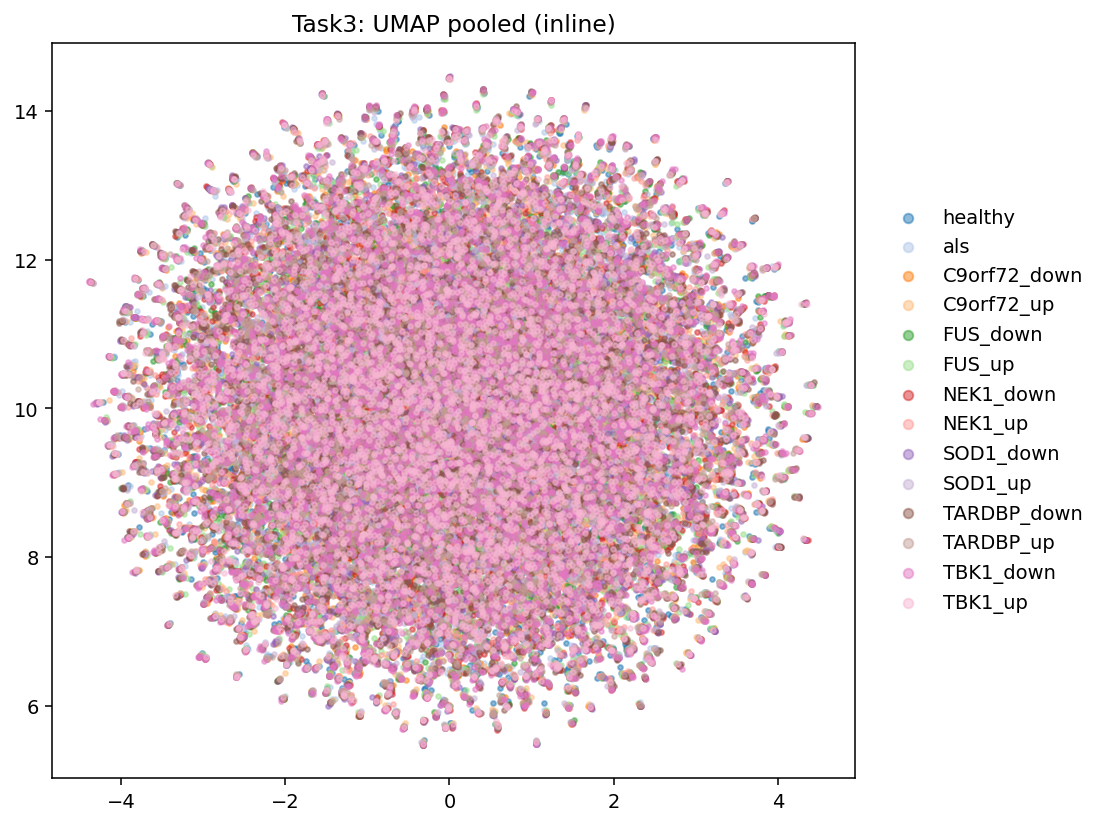

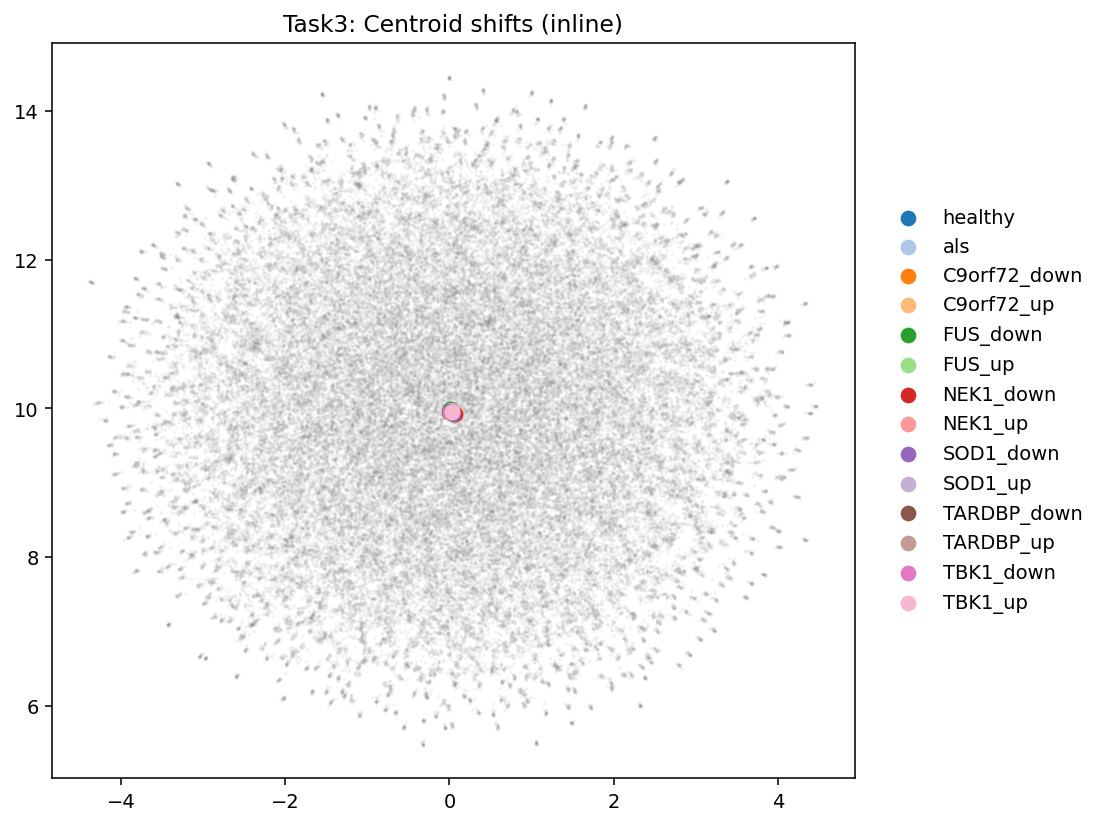

,perturbation,delta_to_healthy,wasserstein_before,wasserstein_after,knn_overlap_gain,silhouette_before,silhouette_after
0,C9orf72_up,0.0,0.0,0.0,0.0,0.000432,0.000432
1,FUS_up,0.0,0.0,0.0,0.0,0.000432,0.000432
2,NEK1_up,0.0,0.0,0.0,0.0,0.000432,0.000432
3,SOD1_up,0.0,0.0,0.0,0.0,0.000432,0.000432
4,TARDBP_up,0.0,0.0,0.0,0.0,0.000432,0.000432
5,TBK1_up,0.0,0.0,0.0,0.0,0.000432,0.000432
6,C9orf72_down,0.0,0.0,0.0,0.0,0.000432,0.000432
7,FUS_down,0.0,0.0,0.0,0.0,0.000432,0.000432
8,NEK1_down,0.0,0.0,0.0,0.0,0.000432,0.000432
9,SOD1_down,0.0,0.0,0.0,0.0,0.000432,0.000432


In [ ]:
# Display saved figures and metrics
from IPython.display import Image, display

# Show saved UMAP plot
umap_path = FIG_DIR / 'task3_umap.png'
if umap_path.exists():
    display(Image(str(umap_path)))
else:
    print("UMAP plot not found")

# Show saved centroid shifts plot
cent_path = FIG_DIR / 'task3_centroid_shifts.png'
if cent_path.exists():
    display(Image(str(cent_path)))
else:
    print("Centroid shifts plot not found")

# Display metrics table sorted by delta_to_healthy
print("\nTop perturbations by delta_to_healthy:")
display(metrics_df.sort_values('delta_to_healthy', ascending=False))

